# Descarga del dataset

In [1]:
%%bash
if [[ ! -d "dataset" ]]; then
  mkdir dataset
  curl -L -o dataset/70-dog-breedsimage-data-set.zip\
    https://www.kaggle.com/api/v1/datasets/download/gpiosenka/70-dog-breedsimage-data-set
  unzip dataset/70-dog-breedsimage-data-set.zip -d dataset
  mv "dataset/valid/American  Spaniel" "dataset/valid/American Spaniel"
fi

# Entrenamiento del modelo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import os
import copy
import time
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import seaborn as sns

data_dir = 'dataset'
data_phases = ['train', 'valid']

# Definir transformaciones
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [3]:
# Cargar los datasets usando ImageFolder
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in data_phases
}

# Crear DataLoaders
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in data_phases
}

# Información del dataset (importante para el modelo)
dataset_sizes = {x: len(image_datasets[x]) for x in data_phases}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

# Configuración del dispositivo (CPU/GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Clases detectadas: {num_classes}")
print(f"Imágenes de Entrenamiento: {dataset_sizes['train']}")
print(f"Imágenes de Validación: {dataset_sizes['valid']}")

Clases detectadas: 70
Imágenes de Entrenamiento: 7946
Imágenes de Validación: 700


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
# Cargar el modelo ResNet18 pre-entrenado
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar todas las capas excepto la capa final (opcional pero recomendado inicialmente)
for param in model_ft.parameters():
    param.requires_grad = False

# Reemplazar la capa final (fully-connected)
# ResNet18 tiene un 'fc' (fully-connected) como capa final
num_ftrs = model_ft.fc.in_features
# La nueva capa de clasificación debe tener 'num_classes' (70) salidas
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

# Definir función de pérdida y optimizador
# Solo estamos optimizando los parámetros que tienen requires_grad=True
# Si se descongelaron todas las capas (para fine-tuning completo), se optimizan todos.
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


In [5]:
# Función principal de entrenamiento
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """
    Función para entrenar y evaluar el modelo.

    Args:
        model (nn.Module): Modelo a entrenar.
        criterion (nn.Module): Función de pérdida.
        optimizer (optim.Optimizer): Optimizador.
        scheduler (optim.lr_scheduler): Programador de la tasa de aprendizaje.
        num_epochs (int): Número de épocas para entrenar.

    Returns:
        nn.Module: El modelo entrenado con la mejor precisión de validación.
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Iterar sobre las épocas
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        # Cada época tiene una fase de entrenamiento y una de validación
        for phase in ['train', 'valid']:
            if phase == 'train':
                # Establecer el modelo en modo de entrenamiento
                model.train()
            else:
                # Establecer el modelo en modo de evaluación
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterar sobre los datos. dataloaders[phase] usa 'train' o 'valid'
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Poner a cero los gradientes de los parámetros
                optimizer.zero_grad()

                # Ejecutar el forward pass y backward pass solo si estamos en 'train'
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimizar solo en fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Ajustar la tasa de aprendizaje después de la fase de entrenamiento
            if phase == 'train':
                scheduler.step()

            # Calcular el promedio de pérdida y precisión para la época
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy de los pesos del mejor modelo (basado en la precisión de validación)
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Entrenamiento completado en {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Mejor precisión de validación: {best_acc:.4f}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    return model

In [6]:
# ReduceLROnPlateau es un scheduler común para Fine-Tuning
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# --- INICIO DEL ENTRENAMIENTO ---
NUM_EPOCHS = 15

model_ft = train_model(
    model_ft,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    num_epochs=NUM_EPOCHS
)


Epoch 1/15
--------------------
train Loss: 3.4805 Acc: 0.2370
valid Loss: 2.2045 Acc: 0.5971

Epoch 2/15
--------------------
train Loss: 2.3247 Acc: 0.5412
valid Loss: 1.3333 Acc: 0.7857

Epoch 3/15
--------------------
train Loss: 1.8373 Acc: 0.6240
valid Loss: 1.0036 Acc: 0.8286

Epoch 4/15
--------------------
train Loss: 1.5892 Acc: 0.6615
valid Loss: 0.8385 Acc: 0.8586

Epoch 5/15
--------------------
train Loss: 1.4237 Acc: 0.6854
valid Loss: 0.7654 Acc: 0.8771

Epoch 6/15
--------------------
train Loss: 1.3319 Acc: 0.6952
valid Loss: 0.7031 Acc: 0.8871

Epoch 7/15
--------------------
train Loss: 1.2468 Acc: 0.7100
valid Loss: 0.6661 Acc: 0.8900

Epoch 8/15
--------------------
train Loss: 1.2107 Acc: 0.7238
valid Loss: 0.6597 Acc: 0.8971

Epoch 9/15
--------------------
train Loss: 1.1966 Acc: 0.7255
valid Loss: 0.6545 Acc: 0.8886

Epoch 10/15
--------------------
train Loss: 1.1967 Acc: 0.7190
valid Loss: 0.6597 Acc: 0.8929

Epoch 11/15
--------------------
train Loss: 1.1

In [7]:
# Guardamos los pesos del modelo entrenado
# torch.save(model_ft.state_dict(), 'resnet18_70_breeds_best_weights.pth')

# Evaluación del modelo

In [8]:
model_ft.eval()

all_labels = []
all_preds = []
all_outputs = []

# Desactivar el cálculo de gradientes para la inferencia
with torch.no_grad():
    # Iterar sobre el DataLoader de validación
    for inputs, labels in dataloaders['valid']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Recopilar etiquetas, predicciones y salidas del modelo
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

# Convertir listas a arrays de numpy
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_score = np.array(all_outputs)
n_classes = len(class_names)


## Métricas de clasificación

In [9]:

# Generar el reporte de clasificación (incluye Precision, Recall, F1-score y Support)
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_names))

# Extraer métricas generales
accuracy_global = report['accuracy']
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']
macro_f1 = report['macro avg']['f1-score']

print("-" * 50)
print(f"Exactitud Global (Accuracy): {accuracy_global:.4f}")
print(f"Precisión (Promedio Macro): {macro_precision:.4f}")
print(f"Sensibilidad (Recall) (Promedio Macro): {macro_recall:.4f}")
print(f"Puntaje F1 (Promedio Macro): {macro_f1:.4f}")
print("-" * 50)



                   precision    recall  f1-score   support

           Afghan       1.00      1.00      1.00        10
 African Wild Dog       1.00      1.00      1.00        10
         Airedale       1.00      0.90      0.95        10
American Hairless       0.00      0.00      0.00        10
 American Spaniel       0.00      0.00      0.00        10
          Basenji       0.91      1.00      0.95        10
           Basset       0.90      0.90      0.90        10
           Beagle       1.00      0.90      0.95        10
   Bearded Collie       1.00      1.00      1.00        10
         Bermaise       1.00      1.00      1.00        10
     Bichon Frise       0.91      1.00      0.95        10
         Blenheim       1.00      1.00      1.00        10
       Bloodhound       0.91      1.00      0.95        10
         Bluetick       1.00      1.00      1.00        10
    Border Collie       1.00      0.80      0.89        10
           Borzoi       1.00      1.00      1.00       

## Matriz de confusión

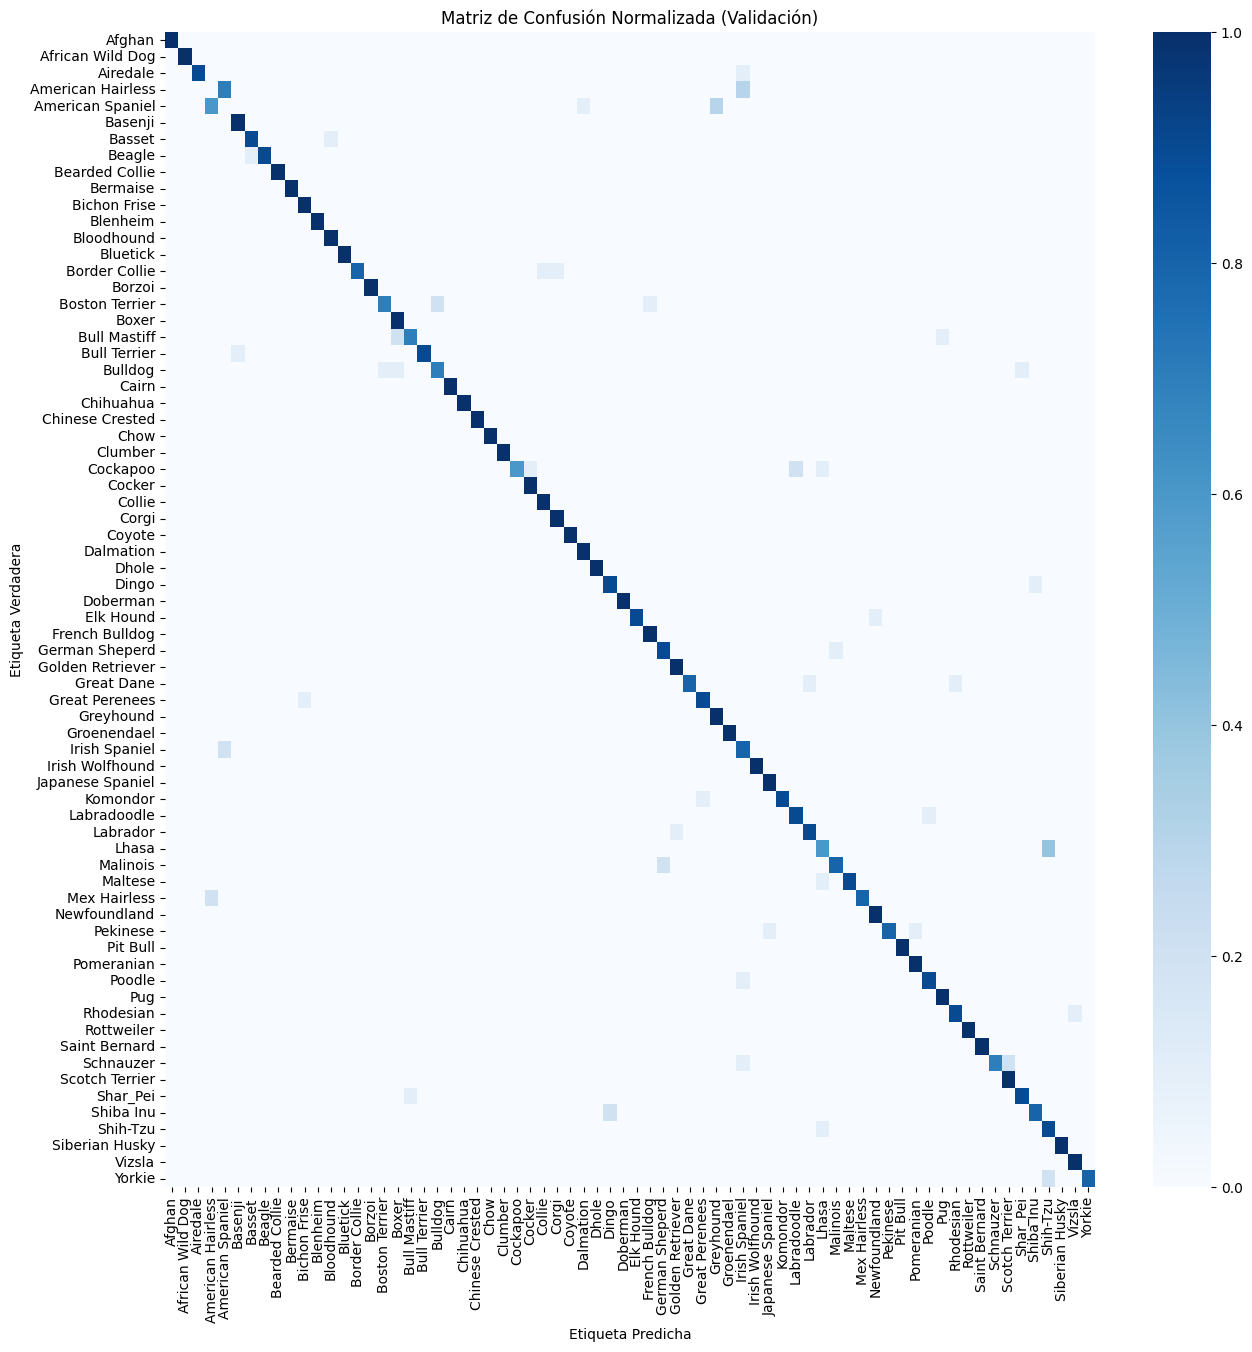

In [10]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Normalizar la matriz de confusión para visualizar porcentajes
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(15, 15))
sns.heatmap(
    cm_normalized,
    annot=False,  # No mostrar números dentro de cada celda para no sobrecargar
    fmt='.2f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Matriz de Confusión Normalizada (Validación)')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()


## Curva ROC

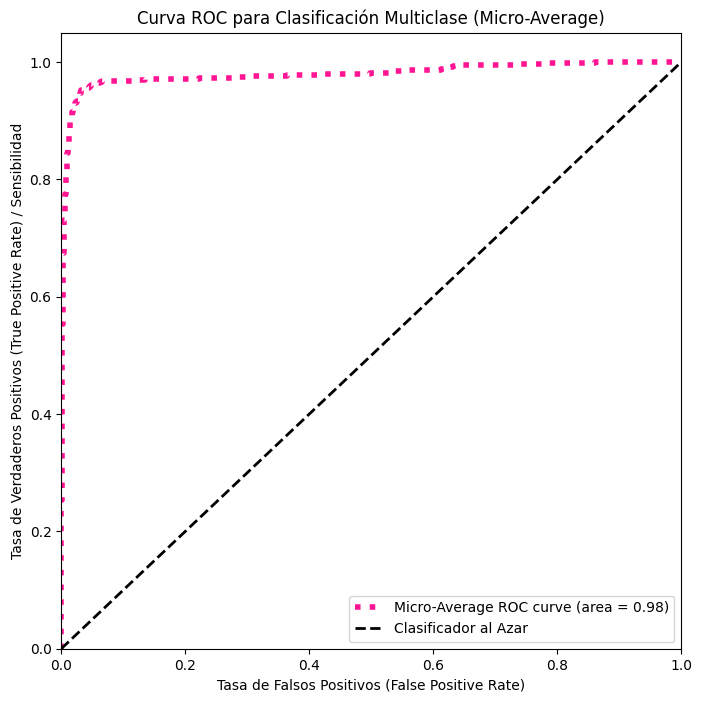

In [11]:

# Para la curva ROC en clasificación multi-clase, se usa el enfoque One-vs-Rest (OvR)
# Binarizar la salida y las etiquetas verdaderas
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Calcular la curva ROC y el AUC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # La salida 'y_score' es directamente el score (logits o probabilidades) para cada clase.
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular el micro-promedio (Micro-average) ROC curve y AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Dibujar la curva ROC Micro-Average
plt.figure(figsize=(8, 8))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f'Micro-Average ROC curve (area = {roc_auc["micro"]:.2f})',
    color='deeppink',
    linestyle=':',
    linewidth=4,
)

# Dibujar la línea de referencia
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Clasificador al Azar')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (False Positive Rate)')
plt.ylabel('Tasa de Verdaderos Positivos (True Positive Rate) / Sensibilidad')
plt.title('Curva ROC para Clasificación Multiclase (Micro-Average)')
plt.legend(loc="lower right")
plt.show()